<a href="https://colab.research.google.com/github/bachaudhry/FastAI-22-23/blob/main/FastAI_2022_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering Deep Dive

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

## Loading and Assessing Data

In [2]:
path = untar_data(URLs.ML_100k)

For reference `untar_data()` stores these downloads in `root/.fastai/data`

In [3]:
# Loading the data from the file u.data which is tab separated with 4
# primary columns. These need to be declared when creating the dataframe
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()


,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# If we already had data on users and their demographics, coupled with
# their movie preferences, then this would be a straight forward exercise in
# calculating dot products like below.
# The movie Last Skywalker would have a set of scores for science-fiction,
# lots of action, and not very old i.e...
last_skywalker = np.array([0.98, 0.9, -0.9])
# a user, on the other hand, might like sci-fi movies with lots of action which
# aren't very old i.e.
user1 = np.array([0.9, 0.8, -0.6])
# The combination, or dot product would give a recommendation score of
round((user1 * last_skywalker).sum(), 3)


2.142

## Learning Latent Factors and Creating Data Loaders

Most of the times, we will be confronted with incomplete matrices of user preferences regarding products on our platform. This complicates the issue of providing them with the correct recommendations.

The preferred approach is to:
1. Randomly initialize some parameters, which will be a set of latent factors for each user and movie. The lesson does not go into a lot of detail about the choosing the number of these factors.
2. Calculate our predictions using dot products of each movie against each user. Strong matches yield higher dot product results, whereas weak matches yield lower dot product results.
3. Finally, calculate the loss.

In [5]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
# Merging the ratings table with movies
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [7]:
ratings.shape

(100000, 5)

In [8]:
# Building a DataLoader
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [9]:
# PyTorch, however, does not allow the usage of direct crosstab representations
# It's simple matrices from here on out! Like so,
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [10]:
# It should be noted that we have to look up the indeces of our movies and users
# latent factor matrices to carry out a dot product operation.
# We can represent look up in an index as a matrix product by replacing indeces
# with one hot encoded vectors. For e.g., multiplying a vector by a one hot
# encoded vector representing the index 3.
one_hot_3 = one_hot(3, n_users).float()

user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

The FastAI implementation of one_hot can be found in [Github](https://https://github.com/fastai/fastai/blob/master/fastai/torch_core.py#L660)

In [11]:
# This is the same vector as the one in index 3
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

## Collaborative Filtering from Scratch

In [12]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)

  def forward(self, x):
    users = self.user_factors(x[:, 0])
    movies = self.movie_factors(x[:, 1])
    return (users * movies).sum(dim=1)

In [13]:
# Creating learner, by using the plainn Learner class
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.371919,1.313460,00:19
1,1.095397,1.090162,00:11
2,0.982468,1.003651,00:12
3,0.855089,0.907152,00:20
4,0.765639,0.889513,00:15


In [14]:
# We can improve the model by introducing a sigmoid range to force the predictions
# to be between 0 and 5
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:, 0])
    movies = self.movie_factors(x[:, 1])
    return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [15]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.980795,0.997819,00:13
1,0.873814,0.905639,00:13
2,0.688293,0.874815,00:14
3,0.480917,0.875623,00:14
4,0.372463,0.879677,00:14


We can improve the model further by considering the following factors:

1. Certain subsets of users may be much more active in their reviews / recommendations, be they positive positive or negative.
2. Some movies are much better or worse than the majority.

The dot product representation needs to have encodings for these additional factors to compliment the weights we encoded in previous sections. We now need to add `biases` to account for peoples likes and dislikes.


In [16]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:, 0])
    movies = self.movie_factors(x[:, 1])
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:, 0]) + self.movie_bias(x[:, 1])
    return sigmoid_range(res, *self.y_range)

In [17]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.960926,0.950450,00:14
1,0.823003,0.876462,00:13
2,0.642411,0.870824,00:13
3,0.403926,0.892137,00:13
4,0.300417,0.899642,00:13


This result is worse than before! The deteriorating validation loss suggests that we are overfitting.

The way forward is to incorporate regularization techniques like `weight decay`.



### What is Weight Decay??

This is simply adding L2 regularization - which is the sum of all weights squared - to the loss function. This ensures that the contribution to gradients is as small as possible.

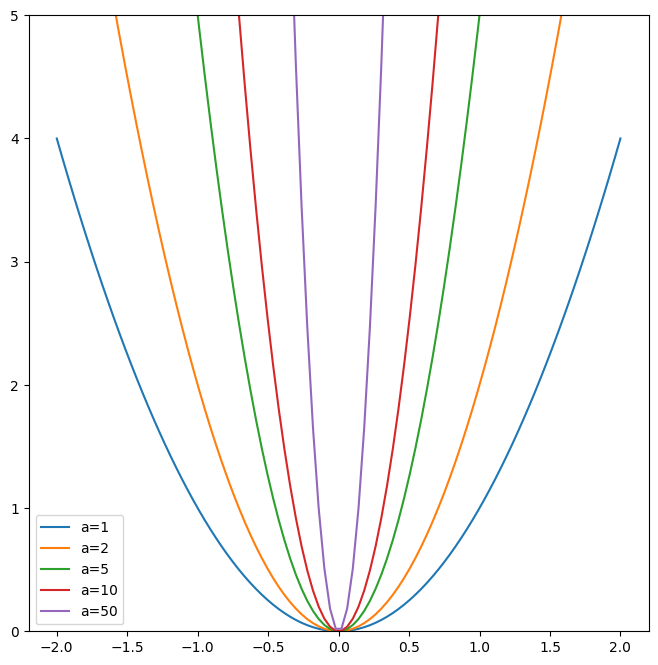

In [18]:
x = np.linspace(-2, 2, 100)
a_s = [1, 2, 5, 10 ,50]
ys = [a * x**2 for a in a_s]

_, ax = plt.subplots(figsize=(8,8))
for a, y in zip(a_s, ys):
  ax.plot(x, y, label=f'a={a}')
  ax.set_ylim([0, 5])
  ax.legend();

In [19]:
# Limiting the weights from growing too much will hinder the training of the model.
# But, the trade-off is that it will generalize better. So, using the derivative
# of p**2 with respect to p, which is 2*p equals
#
# parameters.grad += wd * 2 * parameters
# Using FastAI's parameter.
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.937224,0.963885,00:12
1,0.836324,0.884583,00:12
2,0.763779,0.837741,00:12
3,0.625566,0.821824,00:12
4,0.494496,0.822900,00:12


### Diving deeper into the Embedding Module.

In [20]:
# Recreating DotProductBias without using the Embedding class.
# The following initialization calls on Module to treat tensor as a parameter.
class T(Module):
  def __init__(self):
    self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [21]:
# PyTorch modules implicitly use nn.Parameter for trainable parameters.
class T(Module):
  def __init__(self):
    self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.7119],
        [ 0.2744],
        [-0.3292]], requires_grad=True)]

In [22]:
# Create tensor as a parameter with random initialization.
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [27]:
# Recreating DotProductBias
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors[x[:, 0]]
    movies = self.movie_factors[x[:, 1]]
    res = (users * movies).sum(dim=1)
    res += self.user_bias[x[:, 0]] + self.movie_bias[x[:, 1]]
    return sigmoid_range(res, *self.y_range)


In [28]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.943886,0.960258,00:19
1,0.836059,0.872238,00:15
2,0.706150,0.833339,00:14
3,0.580081,0.821076,00:14
4,0.463032,0.821742,00:14


## Embedding Interpretation

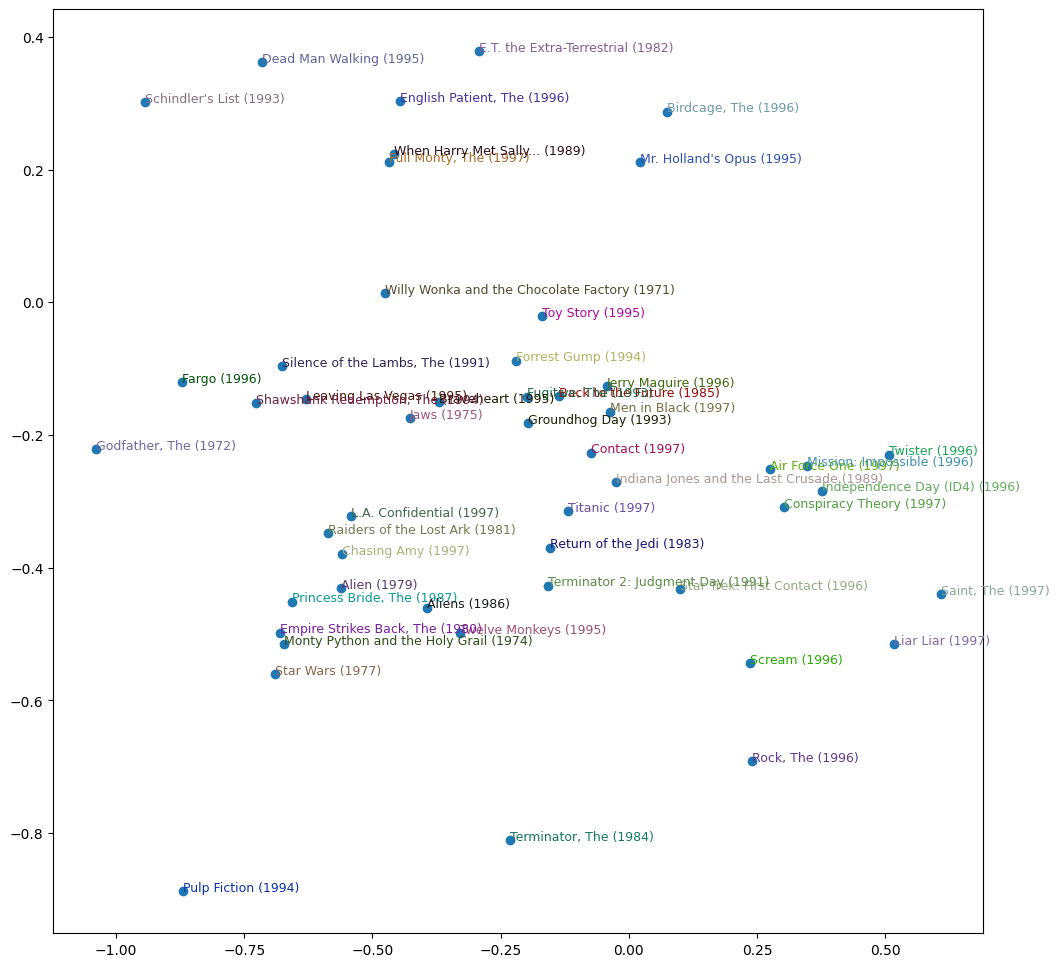

In [32]:
# Carrying out PCA, taking the top 2 components and plotting in 2D
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])

movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()

idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]

plt.figure(figsize=(12, 12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
  plt.text(x, y, i, color=np.random.rand(3) * 0.7, fontsize=9)
plt.show()

## Deep Learning for Collaborative Filtering

In [33]:
# The first step is to take the results of the embedding lookup and concatenate
# the activations. The matrix can then be passed through linear layers and non-
# linearities. The following FastAI function returns the recommended sizes for
# embeddings matrices based on their heuristics.
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [34]:
# Implementing
class CollabNN(Module):
  def __init__(self, user_sz, item_sz, y_range=(0, 5.5), n_act=100):
    self.user_factors = Embedding(*user_sz)
    self.item_factors = Embedding(*item_sz)
    self.layers = nn.Sequential(
        nn.Linear(user_sz[1] + item_sz[1], n_act),
        nn.ReLU(),
        nn.Linear(n_act, 1)
    )
    self.y_range = y_range

  def forward(self, x):
    embs = self.user_factors(x[:, 0]), self.item_factors(x[:, 1])
    x = self.layers(torch.cat(embs, dim=1))
    return sigmoid_range(x, *self.y_range)

In [35]:
model = CollabNN(*embs) # using embs from before
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.943857,0.951898,00:22
1,0.914400,0.899157,00:17
2,0.849325,0.883750,00:17
3,0.814165,0.876096,00:20
4,0.763594,0.877862,00:18
